# CS/ECE/ISyE 524 - Spr 2022 - HW 5 - Solutions


## 1. Spline fitting

We are running a series of experiments to evaluate the properties of a new 
uorescent material. As we vary the intensity of the incident light, the material should fluoresce
different amounts. Unfortunately, the material isn't perfectly uniform and our method for measuring

Fluorescence is not very accurate. After testing 200 different intensities, we obtained the result below
(also available in `xy_data.csv`). The intensities $x_i$ and 
uorescences $y_i$ are recorded in the first and second columns of the data matrix, respectively.

The material has interesting nonlinear properties, and we would like to characterize the relationship
between intensity and fluorescence by using an approximate model that agrees well with the trend of
our experimental data. Although there is noise in the data, we know from physics that the fluorescence
must be zero when the intensity is zero. This fact must be reflected in all of our models!

**a)** Polynomial fit. Find the best cubic polynomial fit to the data. In other words, look for a
function of the form $y = a_1x^3 + a_2x^2 + a_3x + a_4$ that has the best possible agreement with the
data. Remember that the model should have zero fluorescence when the intensity is zero! Include
a plot of the data along with your best-fit cubic on the same axes.

**b)** Spline fit. Instead of using a single cubic polynomial, we will look for a fit to the data using two
quadratic polynomials. Specifically, we want to find coeficients pi and qi so that our data is well
modeled by the piecewise quadratic function:
$$
y = \begin{cases}
p_1x^2 + p_2x + p_3 & \text{if }0 \le x < 4 \\
q_1x^2 + q_2x + q_3 & \text{if }4 \le x < 10
\end{cases}
$$

These quadratic functions must be designed so that:
* as in the cubic model, there is zero fluorescence when the intensity is zero.
* both quadratic pieces have the same value at $x = 4$.
* both quadratic pieces have the same slope at $x = 4$.
In other words, we are looking for a smooth piecewise quadratic. This is also known as a spline
(this is just one type of spline, there are many other types!). Include a plot of the data along with
your best-fit model.

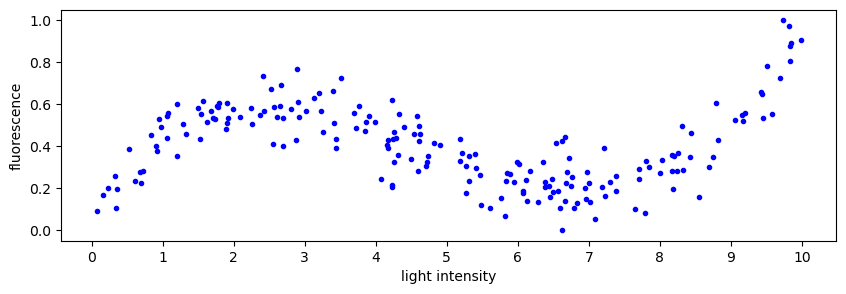

In [34]:
# plot the original data for the problem
using PyPlot, JuMP, Gurobi, CSV, DataFrames
A = CSV.read("xy_data.csv", DataFrame)
x = A[:,1]
y = A[:,2]

using PyPlot
function plotpoints()
    figure(figsize=(10,3))
    plot(x,y,"b.")
    xlabel("light intensity")
    ylabel("fluorescence")
    xticks(0:10)
end
   
plotpoints()
;

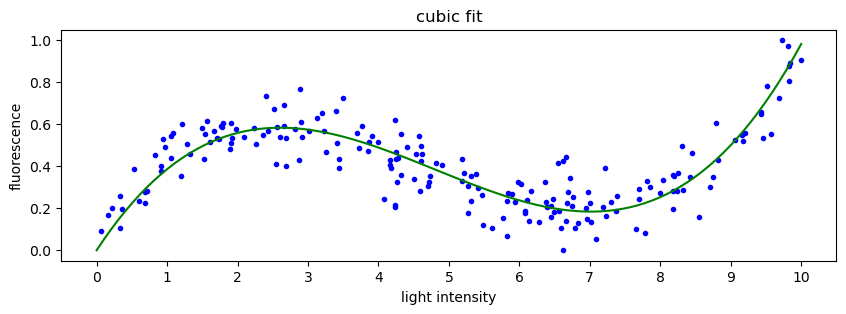

In [35]:
# solve the first part; cubic fit (this is just a least squares problem!)

n = length(x)
Amat = [x.^3 x.^2 x]   # cubic of the form y = ax^3+bx^2+cx (no constant term so that y(0)=0)
w = Amat\y;

plotpoints()
xvals = range(0,stop=10,length=100)
yvals = w[1]*xvals.^3 + w[2]*xvals.^2 + w[3]*xvals
plot(xvals,yvals,"g-")
title("cubic fit")
;

In [36]:
indlo = findall(x .< 4)
xlo = x[indlo]
ylo = y[indlo]

indhi = findall(x .>= 4)
xhi = x[indhi]
yhi = y[indhi]

xlo

75-element Vector{Float64}:
 0.067153
 0.15487
 0.22513
 0.32601
 0.33604
 0.35763
 0.52677
 0.60471
 0.67993
 0.68806
 0.71445
 0.8347
 0.90823
 ⋮
 3.3949
 3.4112
 3.4388
 3.4446
 3.5022
 3.6892
 3.7241
 3.7627
 3.8462
 3.8677
 3.9094
 3.9926

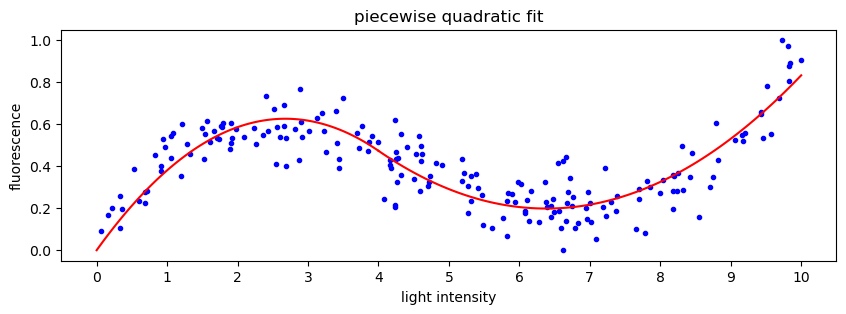

Academic license - for non-commercial use only - expires 2022-08-07
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 3 rows, 6 columns and 11 nonzeros
Model fingerprint: 0x96235c56
Model has 12 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+01, 5e+03]
  QObjective range [2e+02, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 9 nonzeros
Presolved model has 9 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 8.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.93167351e+01  

In [37]:
# solve the second part; piecewise quadratic (this is a QP)

indlo = findall(x .< 4)
xlo = x[indlo]
ylo = y[indlo]

indhi = findall(x .>= 4)
xhi = x[indhi]
yhi = y[indhi]

using JuMP, Gurobi

m = Model(with_optimizer(Gurobi.Optimizer))

@variable(m,p[1:3])  # first segment
@variable(m,q[1:3])  # second segment

@constraint(m, p[3] == 0 )                                             # passes through the origin
@constraint(m, 16*p[1] + 4*p[2] + p[3] == 16*q[1] + 4*q[2] + q[3])   # function values match at x=4
@constraint(m, 2*4*p[1] + p[2] == 2*4*q[1] + q[2])                     # derivatives match at x=4



@objective(m, Min, sum((xlo[i]^2*p[1] + xlo[i]*p[2] + p[3] - ylo[i])^2 for i in 1:length(indlo)) + sum((xhi[i]^2*q[1] + xhi[i]*q[2] + q[3] - yhi[i])^2 for i in 1:length(indhi)))

optimize!(m)

xlovals = range(0,stop=4,length=100)
one=ones(100)
popt = JuMP.value.(p)
ylovals = popt[1]*xlovals.^2 + popt[2]*xlovals + popt[3]*one
xhivals = range(4,stop=10,length=100)
qopt = JuMP.value.(q)
yhivals = qopt[1]*xhivals.^2 + qopt[2]*xhivals + qopt[3]*one

plotpoints()
plot(xlovals,ylovals,"r-")
plot(xhivals,yhivals,"r-")
title("piecewise quadratic fit")
;

## 2. Voltage Smoothing

We would like to send a sequence of voltage inputs to the manipulator
arm of a robot. The desired signal of target voltages
$v^{\text{target}}_i$, $i=1,2,\dotsc,200$ is shown in the plot given with the homework
(also available in 'voltages.csv').

Unfortunately, abrupt changes in voltage cause undue wear and tear on
the motors over time, so we would like to create a new signal that is
similar to the one above but with smoother transitions. For the
sequence of voltages $v_1,v_2,\dots,v_{200}$, one way to characterize
smoothness is via the sum of squared differences:
$$
R(v) = (v_2 - v_1)^2 + (v_3 - v_2)^2 + \dots + (v_{200} - v_{199})^2 =
\sum_{i=1}^{199} (v_{i+1}-v_i)^2.
$$
When R(v) is smaller, the voltage is smoother. Solve a regularized least squares problem that explores the tradeoﬀ between matching the desired signal perfectly and making the signal smooth. Include a plot comparing the original signal to a few diﬀerent smoothed versions obtained using regularized least squares and with varying degrees of smoothness.






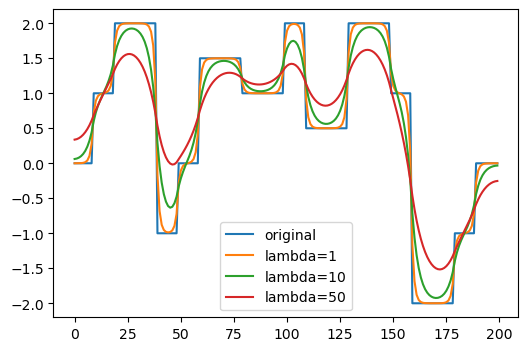

Academic license - for non-commercial use only - expires 2022-08-07
Academic license - for non-commercial use only - expires 2022-08-07
Academic license - for non-commercial use only - expires 2022-08-07
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 0 rows, 200 columns and 0 nonzeros
Model fingerprint: 0xf642dbf6
Model has 399 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 4e+00]
  QObjective range [4e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 0 rows, 200 columns, 0 nonzeros
Presolved model has 399 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 399
 AA' NZ     : 4.700e+02
 Factor NZ  : 2.449e+03
 Factor Ops : 3.695e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                

PyObject <matplotlib.legend.Legend object at 0x0000000069D6A250>

In [38]:
using CSV, Gurobi, DataFrames
vtarget0 = CSV.read("voltages.csv", DataFrame)
m,n=size(vtarget0)
vtarget = [vtarget0[:,1]...,0] 
using PyPlot, JuMP, Gurobi

# Set up the  regularized least-squares problem with regularization parameter lambda

m = Model(with_optimizer(Gurobi.Optimizer))
m1 = Model(with_optimizer(Gurobi.Optimizer))
m2 = Model(with_optimizer(Gurobi.Optimizer))

lambda=1.0   # just try one such parameter
@variable(m, v[1:200])
@objective(m, Min, sum((v.-vtarget).^2)+lambda*sum((v[i+1]-v[i])^2 for i in 1:199))
optimize!(m)
println(JuMP.objective_value(m))
v1=JuMP.value.(v)

lambda=10.0   # just try one such parameter
@variable(m1, v[1:200])
@objective(m1, Min, sum((v.-vtarget).^2)+lambda*sum((v[i+1]-v[i])^2 for i in 1:199))
optimize!(m1)
println(JuMP.objective_value(m1))
v2=JuMP.value.(v)

lambda=50.0   # just try one such parameter
@variable(m2, v[1:200])
@objective(m2, Min, sum((v.-vtarget).^2)+lambda*sum((v[i+1]-v[i])^2 for i in 1:199))
optimize!(m2)
println(JuMP.objective_value(m2))
v3=JuMP.value.(v)
# plot results
figure(figsize=(6, 4))
plot(vtarget)
plot(v1)
plot(v2)
plot(v3)
legend(["original", "lambda=1","lambda=10", "lambda=50"])